# Week 3. MNIST handwritten digit classification with MLP

Today, we will implement multi-layer perceptron(**MLP**) model and its training pipeline using **PyTorch**.

First, let's import required libraties.
 - *torch / torchvision* : Required for learning
 - *numpy / matplotlib.pyplot* : Visualization

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

from sys import stdout

cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

Using PyTorch version: 1.8.1+cu111 CUDA: True


## 0. Preparing MNIST Data

Next we'll load the MNIST data.  First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for *validation*, instead of testing the final model.

In [ ]:
batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# This will automatically download MNIST data into ./data directory
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,    
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)  

validation_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False, **kwargs)

Now let's check if MNIST dataset is properly loaded. We'll see first entry of `train_loader.dataset` using `__getitem__` method.

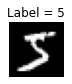

In [ ]:
# Retrieve single item first entry in 'train_loader'
train_image_0, train_label_0 = train_loader.dataset.__getitem__(0)  # In Data-Label order

plt.figure(figsize=(1,1))
plt.axis('off')
_ = plt.imshow(train_image_0.numpy().reshape(28,28), cmap="gray")
_ = plt.title("Label = " + str(train_label_0))

The train and test data are provided via data loaders that provide iterators over the datasets. Recall that both `train_loader` and `validation_loader` are  `DataLoader` class. While previous code only retrieves single element from `train_loader`, we wish to use whole data for training. In this case, we use `for` loop over dataloader to iterate over entire dataset.


In [ ]:
for (X_train, Y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('Y_train:', Y_train.size(), 'type:', Y_train.type())
    break


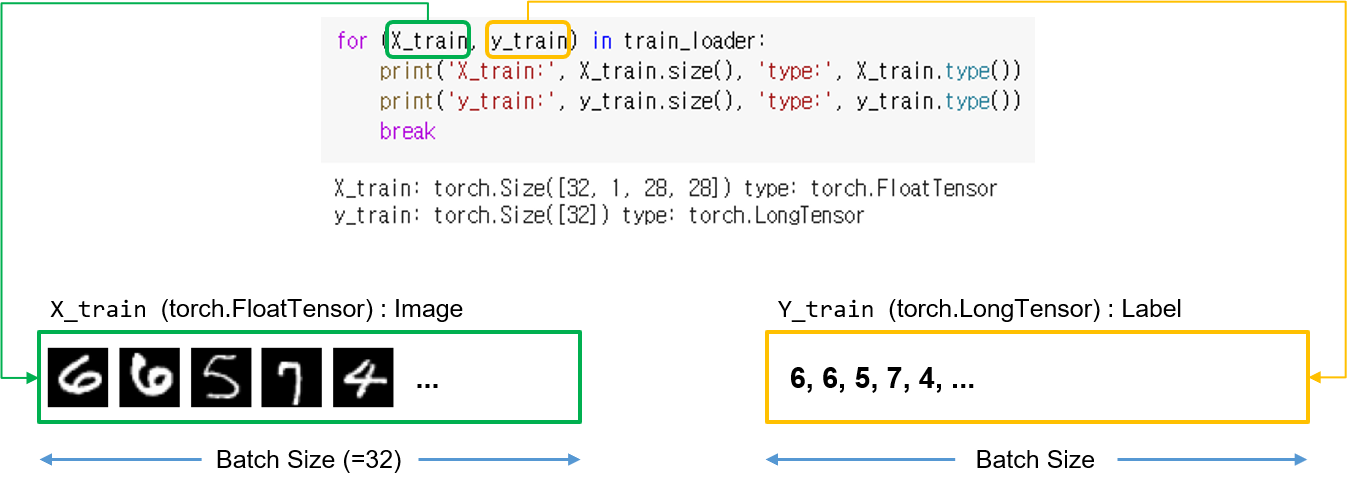

Using `for` loop on `train_loader` will automatically iterate over entire dataset in **batch-size** manner. `X_train` and `Y_train` each indicates handwritten images and their corresponding labels. You can see that `X_train` has dimension of [`batch_size`, 1, 28, 28], which is identical to *(Batch size) x (Channels) x (Width) x (Height)*. `Y_train` has dimension of [`batch_size`], containing correct classes ("0", "1", ..., "9").

Here are the first 5 training digits:

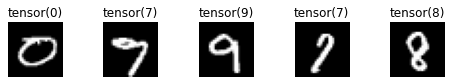

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(1,6):
    plt.subplot(1,6,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title(str(Y_train[i]))

---
## 1. Network definition
First, we will define our own model. Today, we are using two types of models; a *single-layer perceptron* and *multi-layer perceptron*. Let's define `MySLP` and `MyMLP` class. Refer to following figures for details. Be sure to match dimensions!

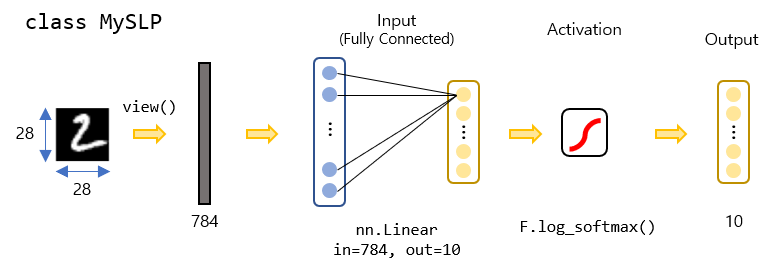

In [ ]:
# Single Layer Perceptron (SLP)
class MySLP(nn.Module):
    def __init__(self):
        super(MySLP, self).__init__()
        self.fc = nn.Linear(784, 10)

    def forward(self, x):
        x = x.view(-1, 784)

        return F.log_softmax(self.fc(x), dim=0)


model_SLP = MySLP()

if cuda:
    model_SLP.cuda()

print(model_SLP)

Now, let's define Multi-Layer Perceptron (**MLP**).

> **Task 1. Implement MyMLP class.**

- Fill in functions `__init__()` and `__forward__()` of `MyMLP` class to define an **MLP** described below.

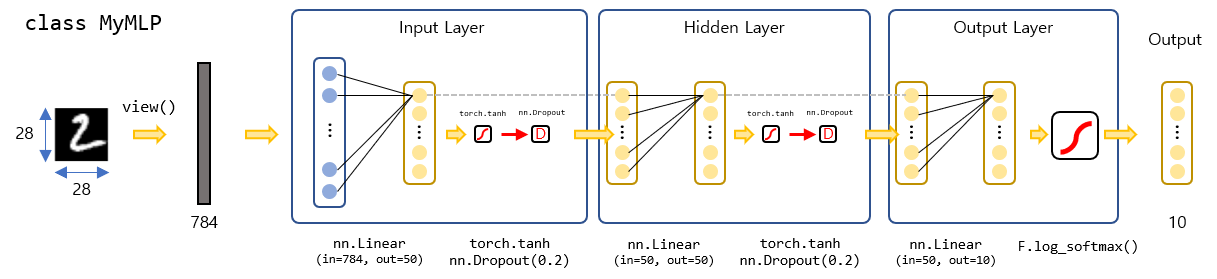


In [ ]:
# Multi Layer Perceptron (MLP)
class MyMLP(nn.Module):
    def __init__(self):
        super(MyMLP, self).__init__()
        self.fc1 =                      
        self.fc2 =                      
        self.fc3 =                      
        self.fc1_drop =                 # nn.Dropout()
        self.fc2_drop =                 # nn.Dropout()

        pass

    def forward(self, x):
        pass


model_MLP = MyMLP()

if cuda:
    model_MLP.cuda()

print(model_MLP)

Finally, we define an optimizer to update the model parameters based on the computed gradients. We use *stochastic gradient descent (SGD)* as the optimization algorithm, and set *learning rate* to 0.01.  Note that there are [several different options](http://pytorch.org/docs/optim.html#algorithms) for the optimizer in PyTorch that we could use instead of *SGD*.

Since there are two models to be trained, we define two optimizers for each models.

In [ ]:
optimizer_SLP = optim.SGD(model_SLP.parameters(), lr=0.01)
optimizer_MLP = optim.SGD(model_MLP.parameters(), lr=0.01)

## 2. Training & Validation Loop

Now we need to train and test our models. Calling `train()` will train a model for single epoch. After each epoch, we call `validate()` to check training progress.

### 2-1. Training
  Training a model has 3 main steps: *Forwarding pass / Loss computation / Backpropagation*.
  
  Below code is commonly required for training step and will likely appear in most of training processes in *PyTorch*.

```
  optimizer.zero_grad()
  output = model(input)
  loss = loss_function(output, target)
  loss.backward()
  optimizer.step()
```

* In the beginning of each loop, `optimizer.zero_grad()` is called to clear *remaining gradients from previous step*.
* Invoking `output = model(input)` will call a `forward()` pass defined in neural network class.
* Compute loss by `loss = loss_function(output, target)`.
* Compute gradients by calling `loss.backward()`.
* Weights are actually updated in `optimizer.step()`.

> **Task 2. Implement `train()` function**

- In this section, you will be asked to **fill in blanks** to complete `train()` function. You may refer to code snippet of *section 2.1*. 
- All blanks are **one-liners**.

In [ ]:
# one training loop for MySLP
def train(model, optimizer, epoch, log_interval=100):
    model.train()   # Set model to training mode
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        # 2-1. Clear remaining gradients by setting to zero        
        
        # 2-2. Call forward() of model
        
        # 2-3. Compute loss (use F.nll_loss)
        
        # 2-4. Compute gradients
        
        # 2-5. Backpropagation by updating weights

        pass

    ## CLI Visualization (Optional) ##
        if (((batch_idx % log_interval) == 0) or (batch_idx == len(train_loader)-1)):
            prog = 100. * (batch_idx+1) / len(train_loader)
            L = int(prog/5)

            stdout.write('\rTrain(SLP) Epoch: {} [{}/{} ({:.0f}%)]\t|'.format(
                epoch, (batch_idx+1) * len(data), len(train_loader.dataset),
                prog) + ("=" * L + ">" + " " * (20-L) + "|") )
            
            stdout.flush()
    stdout.write("\n")
    ## CLI Visualization End ##

### 2-2. Validation
During the training process, we would like to make sure that our model is well trained. Therefore, we are using *validation set* to test generalization capability of our model(s). In following validation function, *validation loss* and *validation accuracy* is computed and tracked in `loss_vector`s.

In [ ]:
def validate(loss_vector_SLP, accuracy_vector_SLP, loss_vector_MLP, accuracy_vector_MLP):
    model_SLP.eval()
    model_MLP.eval()

    val_loss_SLP, correct_SLP = 0, 0
    val_loss_MLP, correct_MLP = 0, 0

    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        output_SLP = model_SLP(data)
        output_MLP = model_MLP(data)

        val_loss_SLP += F.nll_loss(output_SLP, target).item()
        val_loss_MLP += F.nll_loss(output_MLP, target).item()
        
        pred_SLP = output_SLP.data.max(1)[1] # get the index of the max log-probability
        correct_SLP += pred_SLP.eq(target.data).cpu().sum()

        pred_MLP = output_MLP.data.max(1)[1] # get the index of the max log-probability
        correct_MLP += pred_MLP.eq(target.data).cpu().sum()

        

    val_loss_SLP /= len(validation_loader)
    val_loss_MLP /= len(validation_loader)

    loss_vector_SLP.append(val_loss_SLP)
    loss_vector_MLP.append(val_loss_MLP)

    accuracy_SLP = 100. * correct_SLP / len(validation_loader.dataset)
    accuracy_vector_SLP.append(accuracy_SLP)

    accuracy_MLP = 100. * correct_MLP / len(validation_loader.dataset)
    accuracy_vector_MLP.append(accuracy_MLP)

    
    
    print('\nValidation set (SLP): Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        val_loss_SLP, correct_SLP, len(validation_loader.dataset), accuracy_SLP))
    print('Validation set (MLP): Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss_MLP, correct_MLP, len(validation_loader.dataset), accuracy_MLP))

Now we are ready to train our model using the `train()` function.  An *epoch* means one pass through the whole training data. After each epoch, we evaluate the model using `test()`. 

In [ ]:
%%time
epochs = 30

lossv_SLP, accv_SLP, lossv_MLP, accv_MLP = [], [], [], []
for epoch in range(1, epochs + 1):
    train(model_SLP, optimizer_SLP, epoch)
    train(model_MLP, optimizer_MLP, epoch)
    validate(lossv_SLP, accv_SLP, lossv_MLP, accv_MLP)

## 2-3. Data Visualization
Finally, we'll visualize how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the test data.

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv_SLP, label="MySLP")
plt.plot(np.arange(1,epochs+1), lossv_MLP, label="MyMLP")
plt.legend()
plt.title('Validation Loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv_SLP, label="MySLP")
plt.plot(np.arange(1,epochs+1), accv_MLP, label="MyMLP")
plt.legend()
plt.title('Validation Accuracy (%)');